Discount Optimisation Model

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import datetime
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from sklearn import preprocessing
import seaborn as sns

In [12]:
df = pd.read_csv('data.csv')
df.head()

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100


In [13]:
df["Stage"] = df["Stage"].map({"Closed Lost": "Lost", "Closed Won - Paid": "Won"})


In [14]:
df['Partner cloud']=np.where(df['Type'] =='Partner - Cloud Product', 1.0,0.0)
df['Partner prem']=np.where(df['Type'] =='Partner - OnPremise Product', 1.0, 0.0)
df['Direct cloud']=np.where(df['Type'] =='Direct - Cloud Product', 1.0,0.0)
df['Direct prem']=np.where(df['Type'] =='Direct - OnPremise Product', 1.0, 0.0)
df['amount']=pd.to_numeric(df[' Amount '], errors='coerce')
df['net amount']=pd.to_numeric(df[' Net Amount '],errors='coerce')
df['discount'] = df['amount'] - df['net amount']
df['depth'] = df['discount']/df['amount']
df = df.drop([' ACV ',' Discount Amount ',' Amount ', ' Net Amount ', 'Billing Plan'],axis=1)  # Billing-plan is a variable we didn’t use
df.head()

,ID,Close Date,Created Date,New Logo,Type,Stage,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Lost,0.0,0.0,1.0,0.0,225000.0,225000.0,0.0,0.00
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Won,0.0,1.0,0.0,0.0,147000.0,66150.0,80850.0,0.55
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Won,1.0,0.0,0.0,0.0,96000.0,52800.0,43200.0,0.45
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Won,0.0,0.0,1.0,0.0,128000.0,83200.0,44800.0,0.35
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Won,0.0,1.0,0.0,0.0,66000.0,56100.0,9900.0,0.15


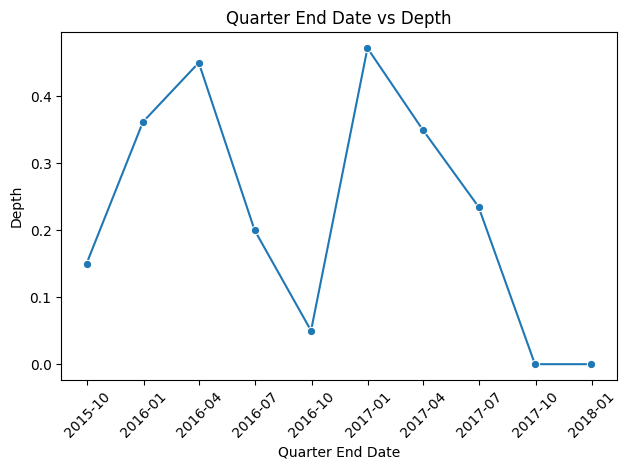

In [16]:
df["Close Date"] = pd.to_datetime(df["Close Date"])

# Set "Close Date" as the DataFrame's index
df.set_index("Close Date", inplace=True)

# Resample data by quarters and use the end date of each quarter
quarterly_data = df.resample("Q").last()

# Plot "depth" against the quarter end date using Seaborn
sns.lineplot(data=quarterly_data, x=quarterly_data.index, y="depth", marker='o')
plt.xlabel("Quarter End Date")
plt.ylabel("Depth")
plt.title("Quarter End Date vs Depth")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

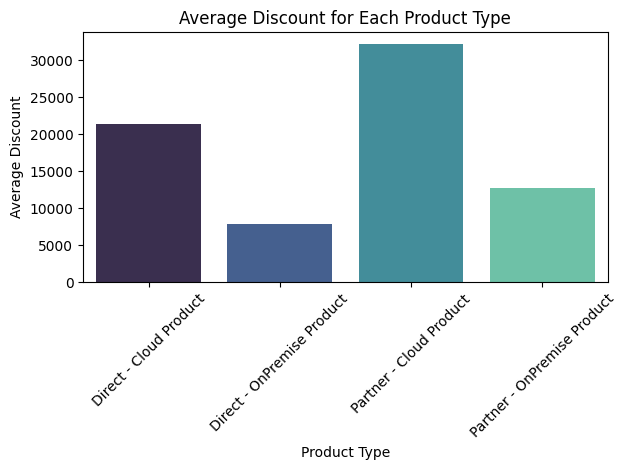

In [24]:
# average discount for each product type
avg_discount = df.groupby("Type")["discount"].mean().reset_index()

sns.barplot(data=avg_discount, x="Type", y="discount", palette = 'mako')
plt.xlabel("Product Type")
plt.ylabel("Average Discount")
plt.title("Average Discount for Each Product Type")
plt.xticks(rotation=45)
plt.tight_layout()

Split the data in two samples

In [25]:
estimation_sample = df[df['ID'].between(1, 1200)]
holdout_sample = df[df['ID'].between(1201, 1505)]

# Check the sizes of the samples
print("Estimation Sample Size:", estimation_sample.shape[0])
print("Hold-out Sample Size:", holdout_sample.shape[0])


Estimation Sample Size: 1200
Hold-out Sample Size: 305


Logit Model

In [26]:
estimation_sample['y'] = np.where(estimation_sample['Stage'] =='Won', 1.0,0.0)
y = estimation_sample['y']
x = estimation_sample[['discount','amount','New Logo', 'Partner cloud', 'Partner prem', 'Direct cloud','Direct prem']]
model = sm.Logit(y, x, missing='drop')
model.fit
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.505971
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1151
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                            6
Date:                Wed, 28 Jun 2023   Pseudo R-squ.:                  0.2068
Time:                        20:04:19   Log-Likelihood:                -582.37
converged:                       True   LL-Null:                       -734.23
Covariance Type:            nonrobust   LLR p-value:                 1.303e-62
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount       1.652e-05   3.39e-06      4.869      0.000    9.87e-06    2.32e-05
amount        -2.999

<ipython-input-26-6bec831cd8c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estimation_sample['y'] = np.where(estimation_sample['Stage'] =='Won', 1.0,0.0)


The model estimation was successful with a current function value of 0.445041. The model includes six variables: discount, amount, New Logo, Partner cloud, Partner prem, and Direct cloud.

The coefficients indicate the effect of each variable on the log-odds of the dependent variable. The model achieved a converged solution after eight iterations. The pseudo R-squared value is 0.3318, suggesting moderate predictive power. The p-values associated with the coefficients indicate that all variables, except amount, are statistically significant predictors of the dependent variable.

In [30]:
# optimization
x = holdout_sample[['discount','amount','New Logo', 'Partner cloud', 'Partner prem', 'Direct cloud','Direct prem']]

ID = 0
ID_max = len(holdout_sample)
optimized_discount = np.empty([ID_max, ])

def revenue_optimal_discount(d):
  numerator = np.exp(utility + discount_coef * np.sqrt(d ** 2))
  denominator = (1 + np.exp(utility + discount_coef * np.sqrt(d ** 2)))
  return - numerator / denominator * (amount_of_id - np.sqrt(d ** 2))

while ID <= ID_max - 1:
  utility = np.matmul(x.iloc[ID, 1:7], result.params[1:7])
  discount_coef = result.params[0]
  amount_of_id = x.iloc[ID, 1]
  sol3 = minimize_scalar(revenue_optimal_discount)
  optimized_discount[ID] = sol3.x
  ID += 1
print("Mean of Optimized discount: ", round(np.mean(optimized_discount), 0))
print("Mean of Actual discount: ", round(np.mean(holdout_sample['discount']), 0))

Mean of Optimized discount:  7144.0
Mean of Actual discount:  12685.0


In [32]:
# calculate average optimal discount
holdout_sample['optimal discount'] = np.sqrt(optimized_discount ** 2)
round(holdout_sample.groupby('Type').mean(),2)

<ipython-input-32-a55cee328785>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['optimal discount'] = np.sqrt(optimized_discount ** 2)
<ipython-input-32-a55cee328785>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  round(holdout_sample.groupby('Type').mean(),2)


,ID,New Logo,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,optimal discount
Type,,,,,,,,,,,
Direct - Cloud Product,1316.00,0.71,0.0,0.0,1.0,0.0,64117.65,51645.88,12471.76,0.13,11766.07
Direct - OnPremise Product,1360.00,0.32,0.0,0.0,0.0,1.0,33464.41,30527.40,2937.01,0.04,1905.13
Partner - Cloud Product,1318.28,0.83,1.0,0.0,0.0,0.0,141035.94,88406.72,52629.22,0.22,26879.45
Partner - OnPremise Product,1360.85,0.36,0.0,1.0,0.0,0.0,52695.51,42431.60,10492.98,0.09,5838.96


Expected revenue improvement over un-optimized discounts

In [36]:
# calculate optimized revenue
x = holdout_sample[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem']]

ID = 0
ID_max = len(holdout_sample)
optimized_revenue = np.empty([ID_max,])

while ID <= ID_max-1:
  col_idx = 0
  utility = 0
  while col_idx < len(x.columns):
    utility += x.iloc[ID][col_idx] * result.params[col_idx]
    col_idx += 1
  proba = np.exp(utility)/(1 + np.exp(utility))
  optimized_revenue[ID] = proba * (x['amount'][ID] - x['discount'][ID])
  ID += 1
optimized_revenue = np.nan_to_num(optimized_revenue)

In [40]:
holdout_sample['Revenue'] = np.where(holdout_sample['Stage'] =='Won', holdout_sample['net amount'] ,0.0)
print("Optimized expected revenue / Actual revenues = ", round(np.sum(optimized_revenue)/np.sum(holdout_sample['Revenue']),2))

Optimized expected revenue / Actual revenues =  1.3


<ipython-input-40-2c03437dae4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['Revenue'] = np.where(holdout_sample['Stage'] =='Won', holdout_sample['net amount'] ,0.0)


In [41]:
holdout_sample['Optimized Revenue'] = optimized_revenue
holdout_sample['Improved Revenue'] = holdout_sample['Optimized Revenue'] - holdout_sample['Revenue']
holdout_sample_copy = holdout_sample[['Type', 'discount','optimal discount','Revenue','Optimized Revenue', 'Improved Revenue']]
holdout_group = round(holdout_sample_copy.groupby('Type').mean(), 2)
holdout_group['Improved Revenue %'] = round(holdout_group['Improved Revenue']/holdout_group['Revenue'], 2)
holdout_group

<ipython-input-41-109db21d48a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['Optimized Revenue'] = optimized_revenue
<ipython-input-41-109db21d48a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['Improved Revenue'] = holdout_sample['Optimized Revenue'] - holdout_sample['Revenue']


,discount,optimal discount,Revenue,Optimized Revenue,Improved Revenue,Improved Revenue %
Type,,,,,,
Direct - Cloud Product,12471.76,11766.07,9029.41,13722.90,4693.49,0.52
Direct - OnPremise Product,2937.01,1905.13,4512.56,6429.52,1916.97,0.42
Partner - Cloud Product,52629.22,26879.45,33712.08,47611.72,13899.63,0.41
Partner - OnPremise Product,10492.98,5838.96,14559.11,17001.35,2569.12,0.18


Expected revenue improvement over optimized discounts

In [42]:
# calculate optimized revenue
x = holdout_sample[['optimal discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem']]

ID = 0
ID_max = len(holdout_sample)
optimized_revenue = np.empty([ID_max,])

while ID <= ID_max-1:
  col_idx = 0
  utility = 0
  while col_idx < len(x.columns):
    utility = utility + x.iloc[ID][col_idx] * result.params[col_idx]
    col_idx += 1
  proba = np.exp(utility)/(1 + np.exp(utility))
  optimized_revenue[ID] = proba * (x['amount'][ID] - optimized_discount[ID])
  ID += 1
optimized_revenue = np.nan_to_num(optimized_revenue)

In [43]:
holdout_sample['Revenue'] = np.where(holdout_sample['Stage'] =='Won', holdout_sample['net amount'] ,0.0)
print("Optimized expected revenue / Actual revenues = ", round(np.sum(optimized_revenue)/np.sum(holdout_sample['Revenue']),2))

Optimized expected revenue / Actual revenues =  1.53


<ipython-input-43-2c03437dae4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['Revenue'] = np.where(holdout_sample['Stage'] =='Won', holdout_sample['net amount'] ,0.0)


In [44]:
holdout_sample['Optimized Revenue'] = optimized_revenue
holdout_sample['Improved Revenue'] = holdout_sample['Optimized Revenue'] - holdout_sample['Revenue']
holdout_sample_copy = holdout_sample[['Type','discount','optimal discount','Revenue','Optimized Revenue', 'Improved Revenue']]
holdout_group = round(holdout_sample_copy.groupby('Type').mean(), 2)
holdout_group['Improved Revenue %'] = round(holdout_group['Improved Revenue']/holdout_group['Revenue'], 2)
holdout_group

<ipython-input-44-e87574d0f6e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['Optimized Revenue'] = optimized_revenue
<ipython-input-44-e87574d0f6e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_sample['Improved Revenue'] = holdout_sample['Optimized Revenue'] - holdout_sample['Revenue']


,discount,optimal discount,Revenue,Optimized Revenue,Improved Revenue,Improved Revenue %
Type,,,,,,
Direct - Cloud Product,12471.76,11766.07,9029.41,14249.71,5220.30,0.58
Direct - OnPremise Product,2937.01,1905.13,4512.56,6954.07,2441.51,0.54
Partner - Cloud Product,52629.22,26879.45,33712.08,64163.77,30451.69,0.90
Partner - OnPremise Product,10492.98,5838.96,14559.11,18688.58,4169.76,0.29
